In [1]:
"""
Aim:
    Classify cervical types -> 1,2 or 3, which are mutually exclusive
    
Scenario:
    Two training sets, one test set, and one prediction set. We are building a model based on samples of medical images, 
    some of which are taken using different equipments -> we will use data augmentations techniques to increase training 
    data size. We Will only use base training images.
    
Model:
    We will build a NN based on some pretrained architectures and fine-tune the model to work with our data. 
"""

'\nAim:\n    Classify cervical types -> 1,2 or 3, which are mutually exclusive\n    \nScenario:\n    Two training sets, one test set, and one prediction set. We are building a model based on samples of medical images, \n    some of which are taken using different equipments -> we will use data augmentations techniques to increase training \n    data size. We Will only use base training images.\n    \nModel:\n    We will build a NN based on some pretrained architectures and fine-tune the model to work with our data. \n'

In [2]:
#import base python modules, numpy and other utilities
import sys, os, re, math, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from time import time
import tempfile
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

In [3]:
#import ML libraries
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras import backend as K
from skimage import measure

#import parts for full network
from tensorflow.keras.applications import DenseNet121, ResNet50, Xception
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.layers import \
                        Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Convolution2D, \
                        BatchNormalization, Flatten, MaxPooling2D, Dropout, Input, Conv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

#import preprocessing 
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

#import result visualisation functions
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [4]:
#check if GPU is loaded properly, should return 2 devices
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [5]:
"""All base training images and add. images were combined into 1 dir. containing 3 folders, [Type_1, ...]. Additional 
images are from the same patients and/or are of worse quality than the training images and will not be used in training."""

'All base training images and add. images were combined into 1 dir. containing 3 folders, [Type_1, ...]. Additional \nimages are from the same patients and/or are of worse quality than the training images and will not be used in training.'

In [6]:
work_dir = os.getcwd()
train_dir = "C:/Users/phann/Coding/Projects/Cervical Cancer ML/Train Directory/"
test_dir = "C:/Users/phann/Coding/Projects/Cervical Cancer ML/Test Directory/"
test_file = pd.read_csv("C:/Users/phann/Coding/Projects/Cervical Cancer ML/test_set_label.csv")

#get number of training images for each type
n_images = 1466
for folder in os.listdir(train_dir):
    x = len(os.listdir(train_dir + str(folder)))
    print("Number of images for {}: {}. As a percentage: {}%".format(str(folder), x, (round(x*100/n_images, 2))))
print("Total number of images:", n_images)
print("Working directory:", work_dir)

#The data is skewed towards Type_2 -> could make our problem stochastic, predicting Type_2 or not Type_2.

Number of images for Type_1: 249. As a percentage: 16.98%
Number of images for Type_2: 772. As a percentage: 52.66%
Number of images for Type_3: 445. As a percentage: 30.35%
Total number of images: 1466
Working directory: C:\Users\phann\Coding\Untitled Folder


In [7]:
#for getting input data
def get_filepath(img_type):
    #get all image file path of its type. Image type has to be in ['Type_1','Type_2','Type_3']
    img_list = [] 
    folder = os.path.join(train_dir, str(img_type))
    for file in glob(os.path.join(folder, "*jpg")):
        img_list.append(file)
    return img_list
def get_img_as_arr(fname):
    #get image data as np.array specifying image id and type from filepath
    img = Image.open(fname)
    img_arr = np.array(img) #img_arr.shape: height x width x channel
    return img_arr
def get_img_dim(fname):
    #get name, tuple of image dimensions from filepath
    name = str(fname).split("/")[-1]
    img = Image.open(fname)
    width, height = img.size
    dimensions = (width, height)
    return name, dimensions

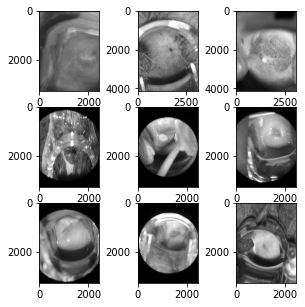

In [8]:
#Get all img paths and names 
types = ['Type_1','Type_2','Type_3']
all_img_names = []
all_img_paths = []
for c_type in types:
    path = get_filepath(c_type)
    all_img_paths += path
    for file in path:
        x = file.split("/")[-1]
        all_img_names.append(x)

#plot out five random entries of all images
fig = plt.figure(figsize=(5, 5))
columns, rows = 3, 3
for i in range(1, columns*rows +1):
    img = all_img_paths[np.random.randint(0, len(all_img_paths))]
    img = Image.open(img).convert('LA')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [9]:
dim_dict = {"Name": [], "Dimensions": []}
sample_size = 500
sampling = False
get_dims = True

if get_dims == True:
    for c_type in types:
        train_path = os.path.join(train_dir, c_type)
        folder = glob(train_path + "/*.jpg")
        if sampling == True:
            #use sampling if data is too large -> look at only a subset of images
            batch = np.random.choice(folder, size=sample_size, replace=False)
            for file in batch:
                name, dim = get_img_dim(file)
                dim_dict["Name"].append(name)
                dim_dict["Dimensions"].append(dim)
        else:
            for file in folder:
                name, dim = get_img_dim(file)
                dim_dict["Name"].append(name)
                dim_dict["Dimensions"].append(dim)
    max_dim = max(dim_dict["Dimensions"])
    min_dim = min(dim_dict["Dimensions"])
    min_dim_list = [dim_dict["Name"][i] for i in range(len(dim_dict["Dimensions"])) if dim_dict["Dimensions"][i] == min_dim]
    print("Max and min dimensions:", max_dim, min_dim)
    print("Number of images at minimum dimensions:", dim_dict["Dimensions"].count(min(dim_dict["Dimensions"])))
    print("Images at minimum dimensions:", ", ".join(repr(e) for e in min_dim_list))

Max and min dimensions: (4128, 3096) (480, 640)
Number of images at minimum dimensions: 6
Images at minimum dimensions: 'Type_1\\1251.jpg', 'Type_1\\833.jpg', 'Type_2\\167.jpg', 'Type_2\\268.jpg', 'Type_2\\354.jpg', 'Type_3\\728.jpg'


In [10]:
#dict with boxes: use this for your local verification
bb_json = {}
type_1_bb_file = pd.read_table("Type_1_bbox.tsv", sep = " ",
                header = None,
                usecols = range(6),
                names = ['filename','nbox','x','y','width','height'])
type_2_bb_file = pd.read_table("Type_2_bbox.tsv", sep = " ",
                header = None,
                usecols = range(6),
                names = ['filename','nbox','x','y','width','height'])
type_3_bb_file = pd.read_table("Type_3_bbox.tsv", sep = " ",
                header = None,
                usecols = range(6),
                names = ['filename','nbox','x','y','width','height'])

In [11]:
bb_files = [type_1_bb_file, type_2_bb_file, type_3_bb_file]
filenames = []
for file in bb_files:
    for index, l in file.iterrows():
        filenames.append(l['filename'])
        bb_json[l['filename'].split('/')[-1]] = sorted([l[['x', 'y', 'width', 'height']].to_dict()], 
                                                   key = lambda var: var['width']*var['height'])
for name in filenames[:3]:
    print(name, bb_json[str(name)])
print("Number of bounding boxes:", len(filenames))
print("We have bounding boxes for {}% of all images".format(round(len(filenames)*100/len(all_img_names), 0)))

Type_1\0.jpg [{'x': 882, 'y': 961, 'width': 1042, 'height': 1106}]
Type_1\10.jpg [{'x': 972, 'y': 2349, 'width': 1052, 'height': 715}]
Type_1\1013.jpg [{'x': 606, 'y': 1437, 'width': 774, 'height': 825}]
Number of bounding boxes: 1466
We have bounding boxes for 100.0% of all images


In [12]:
#decide whether to keep the low res/bad images; remove images that do not have bounding boxes, due to being low quality
scan = False
remove_lowres = False
pruning = True
img_size_threshold = 307200 #480x640, or another custom res from the data

if scan == True:
    for c_type in types:
        train_path = os.path.join(train_dir, c_type)
        folder = glob(train_path + "/" + "*.jpg")
        for file in folder:
            name, dim = get_img_dim(file)
            totalsize = dim[0]*dim[1]
            if name not in filenames:
                print("Removed this file: ", name)
                os.remove(file)
            if totalsize <= img_size_threshold and remove_lowres == True:
                print("Removed this file: ", name)
                os.remove(file)
#check if number of bounding boxes = number of images to be inputted
pruning = True
if pruning == True:
    for name in filenames:
        if name not in all_img_names:
            print(name)

In [13]:
#for computing and plotting bounding boxes
def get_bb(filelist):
    #concatenate all tsv tables into 1 dataframe. Assumes all tsv tables have the same columns
    lst = []
    for filename in filelist:
        df = pd.read_csv(filename, index_col=None, header=0)
        lst.append(df)
    frame = pd.concat(lst, axis=0, ignore_index=True)
    return frame
def to_plot(img):
    #reverse color channels
    return np.rollaxis(img, 0, 3).astype(np.uint8)
def create_rect(bb, color):
    #create a rectangle out of [x, y, width, height]
    return plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], color=color, fill=False, lw=3)
def show_bb(directory, i):
    #plot out bounding box. We don't want to plot out everything -> use index to control what to plot
    img = Image.open(os.path.join(directory, filenames[i])).convert('LA')
    bb = bb_json[filenames[i].split('/')[-1]][0]
    plt.figure(figsize=(2,2))
    s = img.size
    plt.imshow(img)
    ax=plt.gca()
    ax.add_patch(create_rect([bb['x'],bb['y'],bb['width'],bb['height']], 'yellow'))

[{'x': 882, 'y': 961, 'width': 1042, 'height': 1106}]
[{'x': 972, 'y': 2349, 'width': 1052, 'height': 715}]
[{'x': 606, 'y': 1437, 'width': 774, 'height': 825}]
1466 1466


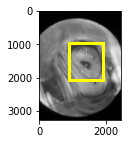

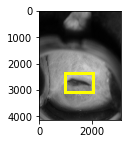

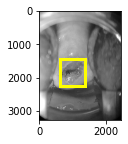

In [14]:
#plot out the first 3 bounding boxes
for i in range(3):
    print(bb_json[str(filenames[i])])
    show_bb(train_dir, i)
print(len(bb_json.items()), len(all_img_names))

In [15]:
#get [x, y, width, height] as a tuple. 2nd function read then crops the bounding box out of the original picture
def get_dict_values(filepath):
    #get 4-tuple of bounding box from valid filepath
    filename = str(filepath).split("/")[-1]
    tup = tuple()
    for key, value in bb_json[str(filename)][0].items():
        tup += (value,)
    return tup
def get_cropped_image(filepath, size):
    #takes filepath, returns cropped image array
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = get_dict_values(filepath)
    #bb_corners = tuple(np.reshape(convert_to_corners(x), newshape=-1))
    cropped_img = img[x[1]:(x[1]+x[3]), x[0]:(x[0]+x[2])]
    cropped_img = cv2.resize(cropped_img, size)
    return cropped_img

In [16]:
#set image loading size, read and preprocess images to np.array (with n_images as shape[0])
t0 = time()
target_sz = (224,224)
all_img = []
for img in all_img_paths:
    all_img.append(np.expand_dims(get_cropped_image(img, target_sz), axis=0))

#stack vertically for later augmentation (make compatible with train_labels_encoded's dimensions)
all_img = np.vstack(all_img)
print(all_img.shape)
print("Time taken:", (time() - t0))

(1466, 224, 224, 3)
Time taken: 244.74392175674438


In [17]:
def get_labels_from_path(path_list):
    #extract labels from file names
    train_labels = []
    for path in path_list:
        x = path.split(".jpg")[0]
        x = x.split("/")[-1]
        x = x.split("\\")[0]
        train_labels.append(x)
    return train_labels

#encode labels -> [0,1,2] -> [0,0,1] for three classes (one-hot)
train_labels = get_labels_from_path(all_img_paths)
train_labels = LabelEncoder().fit_transform(train_labels)
train_labels_encoded = LabelBinarizer().fit_transform(train_labels)
print(train_labels.shape)

(1466,)


In [18]:
weights_dict = dict(zip(np.unique(train_labels), compute_class_weight(class_weight="balanced", 
                                                                      classes=np.unique(train_labels), 
                                                                      y=np.ravel(train_labels))))
print("Weights to be used:", weights_dict)

Weights to be used: {0: 1.962516733601071, 1: 0.6329879101899827, 2: 1.09812734082397}


In [19]:
x_train, x_val, y_train, y_val = train_test_split(all_img, 
                                                  train_labels_encoded, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True, 
                                                  stratify=train_labels)

In [20]:
#Hyperparameters
batchsize = 2
rand_seed = None

In [21]:
def data_aug(x_train, y_train, x_val, y_val):
    #augment training images. Note that validation data is NOT augmented
    train_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=[0.7,1.3],
        brightness_range=[0.8,1.2],
        vertical_flip=True,
        horizontal_flip=True,
        data_format="channels_last",
    )
    #generate training data flow
    aug_train = train_gen.flow(
        x=x_train,
        y=y_train,
        batch_size=batchsize,
        seed=rand_seed,
        shuffle=shuffling,
    )
    #normalise validation images
    val_gen = ImageDataGenerator(
        data_format="channels_last")
    aug_val = val_gen.flow(
        x=x_val,
        y=y_val,
        batch_size=batchsize,
        seed=0,
        shuffle=False,
    )
    return aug_train, aug_val

In [22]:
def test_data_gen(batchsize, target_sz):
    #Test_gen is not augmented. Either have directory manually set or make x_col in flow absolute paths
    test_gen = ImageDataGenerator(rescale=1.0/255, data_format="channels_last", preprocessing_function=xception_preprocess)
    #generate validation data flow
    aug_test = test_gen.flow_from_dataframe(
        dataframe=test_file,
        directory=test_dir,
        x_col="image_name",
        y_col="Type",
        batch_size=batchsize,
        color_mode="rgb",
        shuffle=False,
        class_mode="categorical",
        target_size=target_sz,
    )
    return aug_test

In [23]:
#generate test data for model evaluation
test_data = test_data_gen(batchsize, target_sz)
true_preds = np.array(test_file["Type"])
true_preds = LabelEncoder().fit_transform(true_preds)
print(true_preds)

Found 512 validated image filenames belonging to 3 classes.
[1 1 0 2 2 1 1 1 1 1 1 2 1 2 1 2 0 1 1 2 0 1 1 0 1 0 1 2 1 2 0 1 1 0 1 2 1
 1 1 0 2 1 1 1 0 2 0 0 2 2 2 0 2 0 2 2 1 1 1 0 2 1 2 1 1 0 2 2 2 2 0 1 1 0
 2 0 2 1 2 0 1 1 1 2 0 1 2 2 1 2 0 1 2 1 1 1 0 2 1 2 0 1 1 0 1 1 1 1 2 2 1
 0 2 2 1 1 1 1 2 1 1 1 2 0 2 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 2 0 2 1 2 1 1
 1 2 0 2 1 2 0 2 1 2 2 1 0 1 1 1 1 0 0 2 0 1 1 2 1 0 1 2 1 1 2 1 2 0 2 1 2
 2 1 1 1 2 1 1 2 0 1 0 0 1 2 2 1 1 1 1 1 2 1 2 2 2 2 1 1 2 1 1 1 1 1 1 1 2
 2 2 2 1 1 1 1 1 1 0 0 1 2 1 1 1 2 1 2 1 1 1 2 1 1 1 0 0 1 0 2 2 2 1 2 1 2
 2 0 2 1 1 0 2 2 1 0 1 2 1 2 2 1 2 1 1 2 2 1 1 1 2 2 1 1 2 2 0 1 1 1 0 2 1
 1 1 2 0 1 2 1 0 0 1 2 2 0 2 2 2 0 1 1 1 0 0 1 1 1 1 1 2 1 2 2 1 2 2 0 0 1
 2 2 2 0 1 1 2 1 1 0 2 0 0 1 1 1 1 1 1 1 2 1 0 0 1 1 2 1 1 1 1 2 1 2 0 1 1
 1 0 2 2 1 1 2 0 1 2 2 1 0 1 1 1 2 2 1 1 1 1 1 2 1 0 1 1 1 1 2 2 0 1 1 1 0
 1 1 2 2 1 2 1 2 0 0 1 2 0 1 1 2 2 1 2 2 1 2 2 0 0 2 2 1 2 1 1 1 1 2 1 1 1
 1 0 1 1 1 0 2 1 2 0 1 2 1 0 0 1 0 1 1 2

In [24]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

In [25]:
def create_model(metrics=METRICS, output_bias=None):
    #can also compute initial bias for better first few epochs
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    #start with pretrained model. Output is 4D tensor block
    img_shape = (target_sz[0], target_sz[1], 3)
    base_model = Xception(weights="imagenet", include_top=False, input_shape=img_shape)
    
    #making input layer; normalize to (-1, 1) similar to xception preprocess_input
    inputs = keras.Input(shape=img_shape)
    norm_layer = layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    model_layer = norm_layer(inputs)
    norm_layer.set_weights([mean, var])
    
    #further model layers
    model_layer = base_model(model_layer)
    model_layer = Dropout(0.7)(model_layer)
    model_layer = Flatten()(model_layer)
    model_layer = Dense(64, activation='relu')(model_layer) 
    final_layer = Dense(3, activation='softmax', bias_initializer=output_bias)(model_layer) 

    #compiling final model
    full_model = Model(inputs, final_layer)
    opt = SGD(learning_rate=0.0015, momentum=0.05, nesterov=True)
    full_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=metrics)
    return full_model

create_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195   

In [26]:
#predict first 10 features
model = create_model()
print(model.predict(np.array(all_img[:10])))

#we want to see what the model performance is like with initial weights
results = model.evaluate(all_img, train_labels_encoded, batch_size=batchsize, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

[[0.28940165 0.14798789 0.56261045]
 [0.30810204 0.2513118  0.44058615]
 [0.17963009 0.25718948 0.56318045]
 [0.23736154 0.36070275 0.4019357 ]
 [0.27308378 0.2231541  0.5037621 ]
 [0.37657726 0.28560528 0.33781746]
 [0.36700594 0.33155715 0.3014369 ]
 [0.29815817 0.27022034 0.4316215 ]
 [0.20976853 0.33819458 0.45203692]
 [0.17831846 0.4004259  0.42125565]]
733/733 [==============================] - 32s 42ms/step - loss: 1.2788 - accuracy: 0.2146 - precision: 0.1181 - recall: 0.0279 - auc: 0.3571
Loss: 1.1768


In [27]:
#initial bias computed using basic definitions
#see http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
initial_bias = [0, 1.1336, 0.582]

model = create_model(output_bias=initial_bias)
print(model.predict(np.array(all_img[:10])))

#we want to see what the model performance is like with new biases
results = model.evaluate(all_img, train_labels_encoded, batch_size=batchsize, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

[[0.18442477 0.4185391  0.39703608]
 [0.21852125 0.4061799  0.37529877]
 [0.05322037 0.38806105 0.5587186 ]
 [0.26350152 0.4998757  0.23662277]
 [0.19883445 0.41414347 0.38702208]
 [0.15109424 0.49568805 0.35321778]
 [0.20247142 0.5529605  0.2445681 ]
 [0.12251889 0.60940576 0.26807538]
 [0.03361785 0.21829683 0.7480854 ]
 [0.08225332 0.3868729  0.5308738 ]]
733/733 [==============================] - 32s 42ms/step - loss: 1.5506 - accuracy: 0.2869 - precision: 0.2192 - recall: 0.0777 - auc: 0.4530
Loss: 1.1640


In [28]:
#save our weights for later use
#model.save_weights(os.path.join(work_dir, "initial_weights.h5"))

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [29]:
model = create_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0, 0.0, 0.0])
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=batchsize,
    epochs=20,
    validation_data=(x_val, y_val), 
    verbose=1)

Epoch 1/20
586/586 [==============================] - 120s 198ms/step - loss: 1.1040 - accuracy: 0.3652 - precision: 0.3682 - recall: 0.1681 - auc: 0.5603 - val_loss: 1.0026 - val_accuracy: 0.4320 - val_precision: 0.4000 - val_recall: 0.1020 - val_auc: 0.6644
Epoch 2/20
586/586 [==============================] - 120s 206ms/step - loss: 0.9265 - accuracy: 0.5776 - precision: 0.6173 - recall: 0.3891 - auc: 0.7485 - val_loss: 0.9477 - val_accuracy: 0.5136 - val_precision: 0.5714 - val_recall: 0.2041 - val_auc: 0.7313
Epoch 3/20
586/586 [==============================] - 124s 212ms/step - loss: 0.8303 - accuracy: 0.6047 - precision: 0.6495 - recall: 0.5089 - auc: 0.8016 - val_loss: 0.9257 - val_accuracy: 0.4796 - val_precision: 0.5395 - val_recall: 0.2789 - val_auc: 0.7352
Epoch 4/20
586/586 [==============================] - 126s 215ms/step - loss: 0.7436 - accuracy: 0.6778 - precision: 0.7149 - recall: 0.5937 - auc: 0.8494 - val_loss: 0.9662 - val_accuracy: 0.4830 - val_precision: 0.5307

In [30]:
model = create_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=batchsize,
    epochs=20,
    validation_data=(x_val, y_val), 
    verbose=1)

Epoch 1/20
586/586 [==============================] - 131s 217ms/step - loss: 1.0791 - accuracy: 0.5315 - precision: 0.5484 - recall: 0.4715 - auc: 0.7048 - val_loss: 0.9573 - val_accuracy: 0.5306 - val_precision: 0.5728 - val_recall: 0.4150 - val_auc: 0.7270
Epoch 2/20
586/586 [==============================] - 127s 217ms/step - loss: 0.9254 - accuracy: 0.5674 - precision: 0.5952 - recall: 0.5014 - auc: 0.7512 - val_loss: 0.9210 - val_accuracy: 0.5578 - val_precision: 0.5887 - val_recall: 0.4626 - val_auc: 0.7483
Epoch 3/20
586/586 [==============================] - 127s 217ms/step - loss: 0.8385 - accuracy: 0.6049 - precision: 0.6299 - recall: 0.5574 - auc: 0.7941 - val_loss: 0.9464 - val_accuracy: 0.5306 - val_precision: 0.5146 - val_recall: 0.4184 - val_auc: 0.7253
Epoch 4/20
586/586 [==============================] - 131s 223ms/step - loss: 0.7765 - accuracy: 0.6532 - precision: 0.6565 - recall: 0.6203 - auc: 0.8204 - val_loss: 1.0041 - val_accuracy: 0.5510 - val_precision: 0.5596

In [31]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'], 
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'], 
                 color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

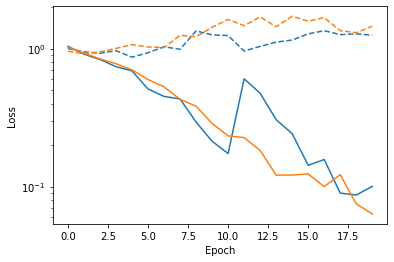

In [34]:
#we will see that bias initialization so that e^B_i/sum(e^B_j) = proportion of ith class in population does not 
#return good enough results compared to 0 initialization, but does appear to lead to more stable optimization
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [42]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], 
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

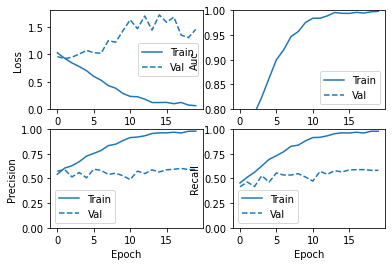

In [44]:
plot_metrics(careful_bias_history)

In [ ]:
#note that val_auc <= 0.7, so it does not show up

In [ ]:
def scheduler(epoch, lr):
    #reduce learning rate exponentially
    if int(epoch) % 2 == 0 and epoch <= 16:
        return lr*np.exp(-0.06)
    elif epoch > 16:
        return lr*np.exp(-0.1)
    else: 
        return lr

In [ ]:
#set up callback components
LRreduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75, patience=4, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", verbose=1, save_best_only=True)
earlystop1 = EarlyStopping(monitor="val_auc", patience=10, verbose=1, mode="max")
earlystop2 = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=8, verbose=1, mode="auto")
lrscheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
#we want to see 
model = create_model(target_sz)

#we want to see what the model performance is like with initial weights
LR = 0.0015
opt = SGD(learning_rate=LR, momentum=0.05, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)

#fit the baseline model
baseline_history = model.fit(
    x_train,
    y_train,
    batch_size=batchsize,
    epochs=20,
    callbacks=[earlystop1],
    validation_data=(x_val, y_val))

In [ ]:
#freeze base layers
for layer in model.layers:
    if "xception" in layer.name:
        layer.trainable = False

#Compile model using SGD with Nesterov adjustment
LR = 0.0015
opt = SGD(learning_rate=LR, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#perform 5-fold stratified split, to maintain imbalance of data when training -> avoid strong bias when training
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cvscores = []
Fold = 1
t0 = time()
for train, val in kfold.split(all_img, train_labels):
    gc.collect()
    K.clear_session()
    print ("Fold: ",Fold)
    
    x_train = all_img[train]
    x_val = all_img[val]
    y_train = train_labels_encoded[train]
    y_val = train_labels_encoded[val]

    aug_train, aug_val = data_aug(x_train, y_train, x_val, y_val)
    callbacks = [checkpoint, lrscheduler]
    history = model.fit_generator(aug_train, 
            steps_per_epoch=x_train.shape[0]//batchsize,
            validation_data=aug_val,
            class_weight=weights_dict,
            epochs=30,
            callbacks=callbacks,
            verbose=2)
    
    # Save each fold model
    model_name = 'CERVimg_Fold'+str(Fold)+'.h5'
    model.save(model_name)
    
    # evaluate the model
    scores = model.evaluate(x_val, y_val, verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    Fold = Fold +1

print("%s: %.2f%%" % ("Mean Accuracy: ", np.mean(cvscores)))
print("%s: %.2f%%" % ("Standard Deviation: +/-", np.std(cvscores)))
print("Time taken:", (time() - t0))

In [ ]:
plt.plot(history.history["accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
#Unfreeze base layers, but keep batchnorm in inference mode -> calculate norm using moving mean and std dev instead
#of batch mean and std dev
for layer in model.layers:
    if "bn" not in layer.name:
        layer.trainable = True  

#recompile model after unfreezing
LR = 1.05e-5
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
    #reduce learning rate exponentially
    if 1 < epoch <= 16:
        return lr*np.exp(-0.02)
    elif epoch > 16:
        return lr*np.exp(-0.1)
    else:
        return lr
lrscheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
cvscores = []
Fold = 1
t0 = time()
for train, val in kfold.split(all_img, train_labels):
    gc.collect()
    K.clear_session()
    print ("Fold: ", Fold)
    
    x_train = all_img[train]
    x_val = all_img[val]
    y_train = train_labels_encoded[train]
    y_val = train_labels_encoded[val]

    aug_train, aug_val = data_aug(x_train, y_train, x_val, y_val)
    callbacks = [checkpoint, lrscheduler]
    history = model.fit_generator(aug_train, 
            steps_per_epoch=x_train.shape[0]//batchsize,
            validation_data=aug_val,
            class_weight=weights_dict,
            epochs=30,
            callbacks=callbacks,
            verbose=1)
    
    # Save each fold model
    model_name = 'FinetunedCERVimg_Fold'+str(Fold)+'.h5'
    model.save(model_name)
    
    # evaluate the model
    scores = model.evaluate(test_data, true_preds, verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    Fold = Fold +1

print("%s: %.2f%%" % ("Mean Accuracy: ", np.mean(cvscores)))
print("%s: %.2f%%" % ("Standard Deviation: +/-", np.std(cvscores)))
print("Time taken:", (time() - t0))

In [ ]:
plt.plot(history.history["accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.show()
plt.plot(history.history["val_accuracy"])
plt.show()
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
pred = model.predict(test_data)
print(pred)
class_preds = np.argmax(pred, axis=-1)
print(class_preds)

test_data = test_data_gen(batchsize, target_sz)
true_preds = np.array(test_file["Type"])
true_preds = LabelEncoder().fit_transform(true_preds)
print(true_preds)

In [ ]:
print(classification_report(true_preds, class_preds))
print(confusion_matrix(true_preds, class_preds, labels=types))

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.15),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)
    ]
)